In [2]:
!pip install -U "monai[all]" pyyaml munch

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 9.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 7.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 9.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
from glob import glob

import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    RandCropByPosNegLabeld,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,

)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.handlers.utils import from_engine
from monai.config import print_config
from monai.apps import download_and_extract
from monai.utils import first
import tempfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils.enums import CommonKeys

In [4]:
print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.6.3
TorchVision version: 0.13.0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.2
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
base_dir='/kaggle/input/prostate158-train2/prostate158_train'
train_csv ='/kaggle/input/prostate158-train2/prostate158_train/train.csv'
valid_csv = '/kaggle/input/prostate158-train2/prostate158_train/valid.csv'

train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)

train_df.fillna(value='', inplace=True)
valid_df.fillna(value='', inplace=True)

In [6]:
train_df.head(5)

ID                       t2                        adc  \
0  24  train/024/t2.nii/t2.nii  train/024/adc.nii/adc.nii   
1  25  train/025/t2.nii/t2.nii  train/025/adc.nii/adc.nii   
2  26  train/026/t2.nii/t2.nii  train/026/adc.nii/adc.nii   
3  27  train/027/t2.nii/t2.nii  train/027/adc.nii/adc.nii   
4  28  train/028/t2.nii/t2.nii  train/028/adc.nii/adc.nii   

                         dwi  \
0  train/024/dwi.nii/dwi.nii   
1  train/025/dwi.nii/dwi.nii   
2  train/026/dwi.nii/dwi.nii   
3  train/027/dwi.nii/dwi.nii   
4  train/028/dwi.nii/dwi.nii   

                                  t2_anatomy_reader1  \
0  train/024/t2_anatomy_reader1.nii/t2_anatomy_re...   
1  train/025/t2_anatomy_reader1.nii/t2_anatomy_re...   
2  train/026/t2_anatomy_reader1.nii/t2_anatomy_re...   
3  train/027/t2_anatomy_reader1.nii/t2_anatomy_re...   
4  train/028/t2_anatomy_reader1.nii/t2_anatomy_re...   

                                    t2_tumor_reader1  \
0                                                      
1  train/025/t2_tumor_reader1.nii/t2_tumor_reader...   
2                                                      
3  train/027/t2_tumor_reader1.nii/t2_tumor_reader...   
4                                                      

                                   adc_tumor_reader1 t2_anatomy_reader2  \
0                             train/024/empty.nii.gz                      
1  train/025/adc_tumor_reader1.nii/adc_tumor_read...                      
2                             train/026/empty.nii.gz                      
3  train/027/adc_tumor_reader1.nii/adc_tumor_read...                      
4                             train/028/empty.nii.gz                      

                                   adc_tumor_reader2  
0                                                     
1  train/025/adc_tumor_reader2.nii/adc_tumor_read...  
2                                                     
3  train/027/adc_tumor_reader2.nii/adc_tumor_read...  
4

In [7]:
valid_df.head(5)

ID                       t2                        adc  \
0  20  train/020/t2.nii/t2.nii  train/020/adc.nii/adc.nii   
1  21  train/021/t2.nii/t2.nii  train/021/adc.nii/adc.nii   
2  22  train/022/t2.nii/t2.nii  train/022/adc.nii/adc.nii   
3  23  train/023/t2.nii/t2.nii  train/023/adc.nii/adc.nii   
4  38  train/038/t2.nii/t2.nii  train/038/adc.nii/adc.nii   

                         dwi  \
0  train/020/dwi.nii/dwi.nii   
1  train/021/dwi.nii/dwi.nii   
2  train/022/dwi.nii/dwi.nii   
3  train/023/dwi.nii/dwi.nii   
4  train/038/dwi.nii/dwi.nii   

                                  t2_anatomy_reader1  \
0  train/020/t2_anatomy_reader1.nii/t2_anatomy_re...   
1  train/021/t2_anatomy_reader1.nii/t2_anatomy_re...   
2  train/022/t2_anatomy_reader1.nii/t2_anatomy_re...   
3  train/023/t2_anatomy_reader1.nii/t2_anatomy_re...   
4  train/038/t2_anatomy_reader1.nii/t2_anatomy_re...   

                                    t2_tumor_reader1  \
0  train/020/t2_tumor_reader1.nii/t2_tumor_reader...   
1  train/021/t2_tumor_reader1.nii/t2_tumor_reader...   
2                                                      
3                                                      
4  train/038/t2_tumor_reader1.nii/t2_tumor_reader...   

                                   adc_tumor_reader1 t2_anatomy_reader2  \
0  train/020/adc_tumor_reader1.nii/adc_tumor_read...                      
1  train/021/adc_tumor_reader1.nii/adc_tumor_read...                      
2                             train/022/empty.nii.gz                      
3                             train/023/empty.nii.gz                      
4  train/038/adc_tumor_reader1.nii/adc_tumor_read...                      

                                   adc_tumor_reader2  
0  train/020/adc_tumor_reader2.nii/adc_tumor_read...  
1  train/021/adc_tumor_reader2.nii/adc_tumor_read...  
2                                                     
3                                                     
4

In [8]:
import numpy as np

In [9]:
t2_mri=train_df[['t2']].squeeze().tolist()
t2_valid=valid_df[['t2']].squeeze().tolist()

mask_files=train_df[['t2_anatomy_reader1']].squeeze().tolist()
vali_masks=valid_df[['t2_anatomy_reader1']].squeeze().tolist()

In [10]:
train_images=[]
valid_images=[]

train_masks=[]
valid_masks=[]

for i in range(len(t2_mri)):
  train_images.append(os.path.join(base_dir,t2_mri[i]))
  train_masks.append(os.path.join(base_dir,mask_files[i]))
  #current_axis_codes = nib.aff2axcodes(nib.load(os.path.join(base_dir,t2_mri[i])).affine)
  #print(current_axis_codes)

for i in range(len(t2_valid)):
  valid_images.append(os.path.join(base_dir,t2_valid[i]))
  valid_masks.append(os.path.join(base_dir,vali_masks[i]))

In [11]:
train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_masks)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(valid_images, valid_masks)]

In [12]:
# load the images
# do any transforms
# need to convert them into troch tensors

orig_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        
        ToTensord(keys=['image', 'label'])
    ]
)

train_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=['image', 'label'], 
                 pixdim=(0.5, 0.5, 0.5)
                 ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys='image', a_min=-200, a_max=200, 
            b_min=0.0, b_max=1.0, clip=True
            ),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        #Resized(keys=['image', 'label'], spatial_size=[256,256,30]),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        ToTensord(keys=['image', 'label'])
    ]
)


val_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=['image', 'label'], 
                 pixdim=(0.5, 0.5, 0.5)
                 ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys='image', a_min=-200, a_max=200, 
            b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=['image', 'label'])
    ]
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [13]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [14]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [15]:
#orig=train_ds[100]['image']

In [16]:
#orig.shape

In [17]:
#im=orig.numpy()

In [18]:
#re=im.reshape(256,256,30)

In [19]:
#lorig=train_ds[100]['label']
#lim=lorig.numpy()
#lre=lim.reshape(256,256,30)

In [20]:
#plt.figure('test', (12, 6))
#plt.subplot(2, 2, 1)
#plt.title('Orig patient')
#plt.imshow(orig[ 0, : ,: ,10])

#plt.subplot(2, 2, 2)
#plt.title('reshaped')
#plt.imshow(re[: ,: ,10])

#plt.figure('test', (12, 6))
#plt.subplot(2, 2, 3)
#plt.title('Orig lab')
#plt.imshow(lorig[ 0, : ,: ,10])

#plt.subplot(2, 2, 4)
#plt.title('reshaped lab')
#plt.imshow(lre[: ,: ,10])

In [21]:
#type(im)

In [22]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(0.5000)
tensor(1.)


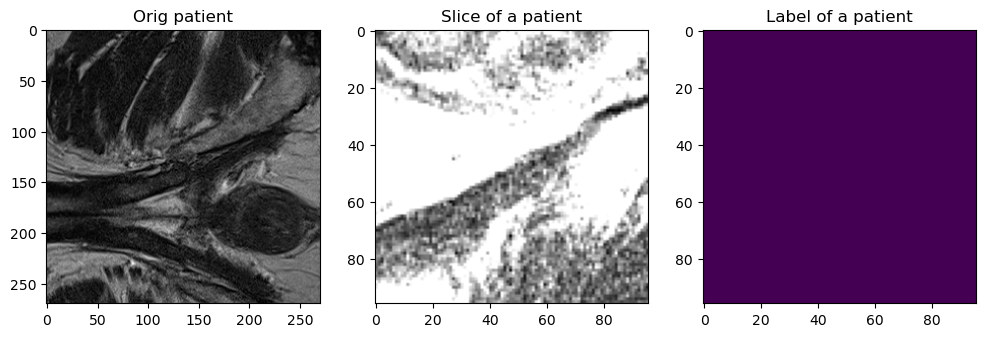

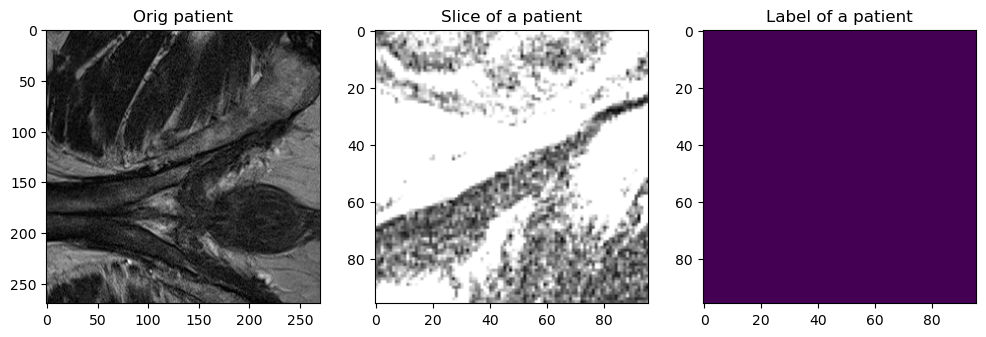

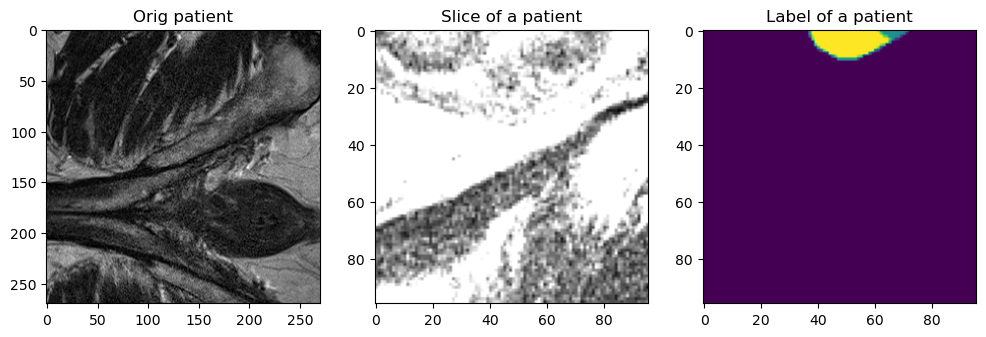

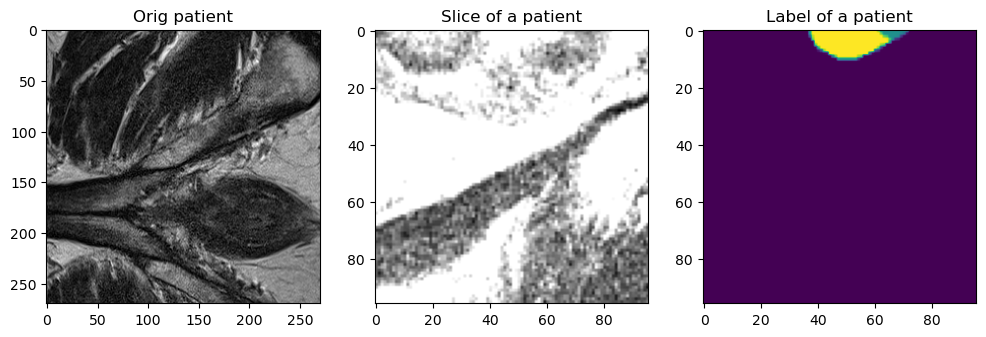

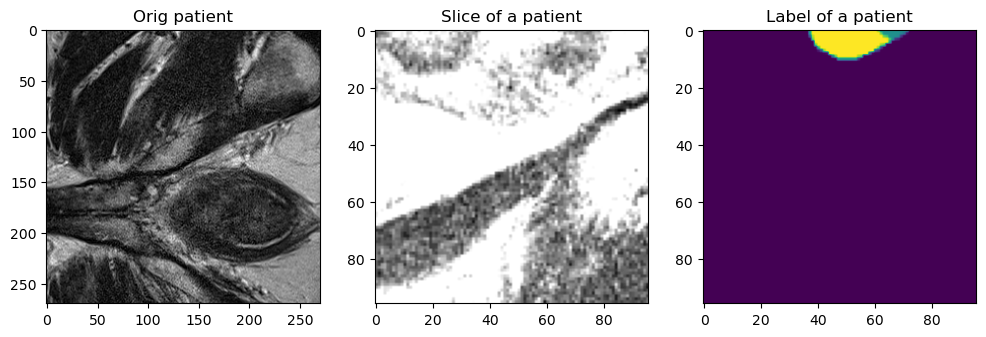

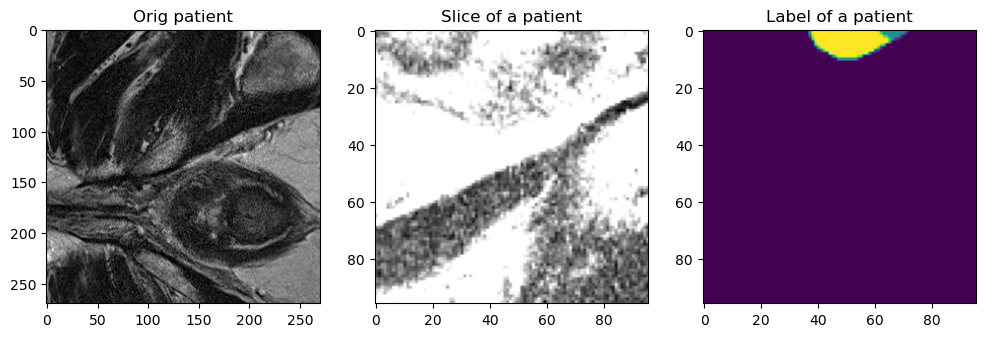

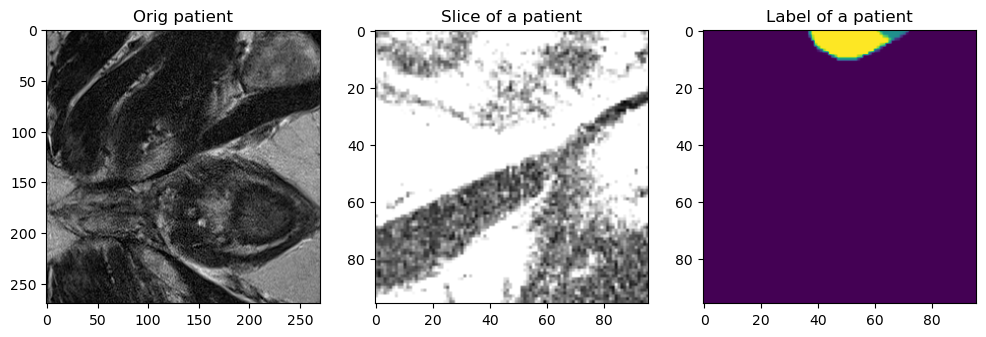

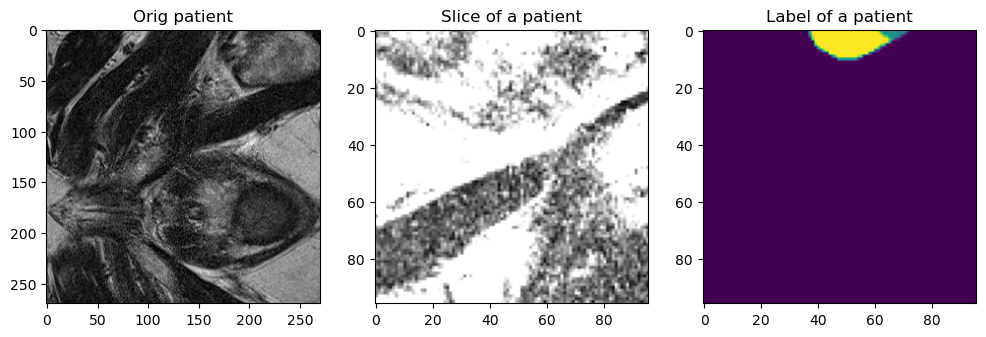

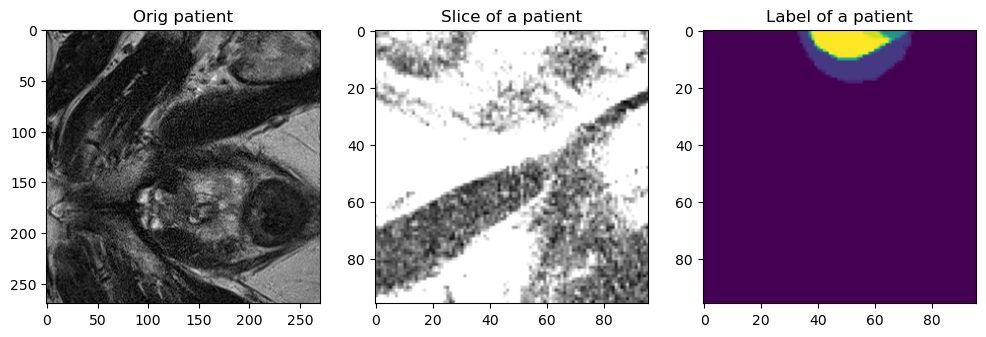

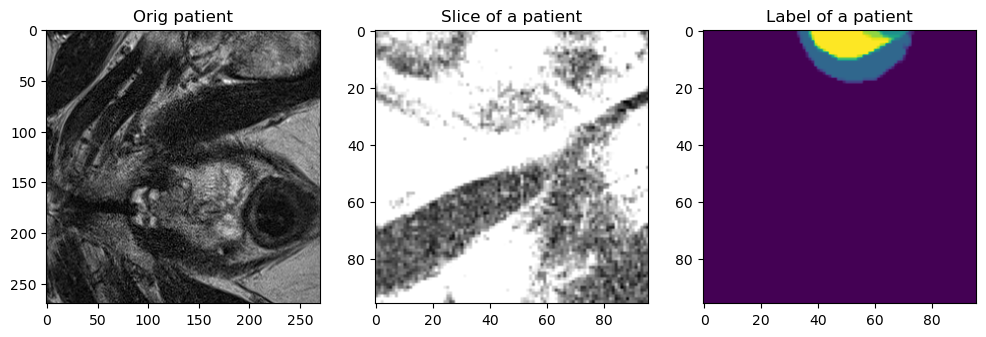

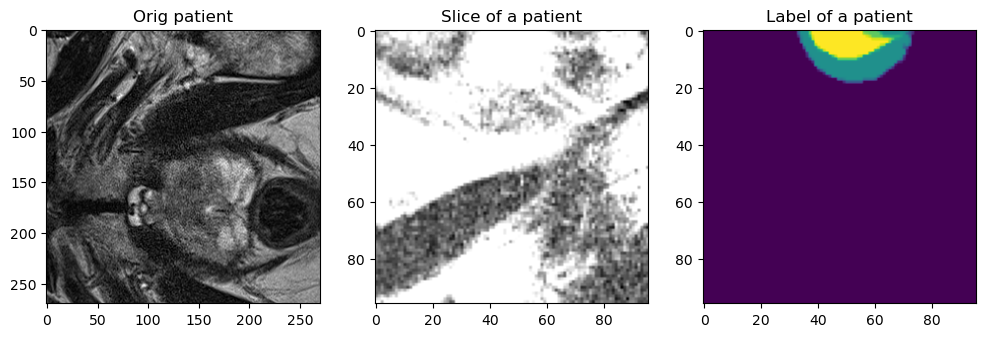

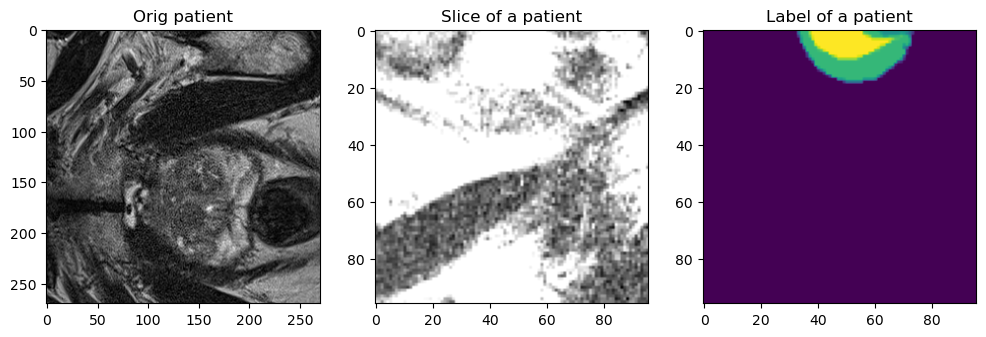

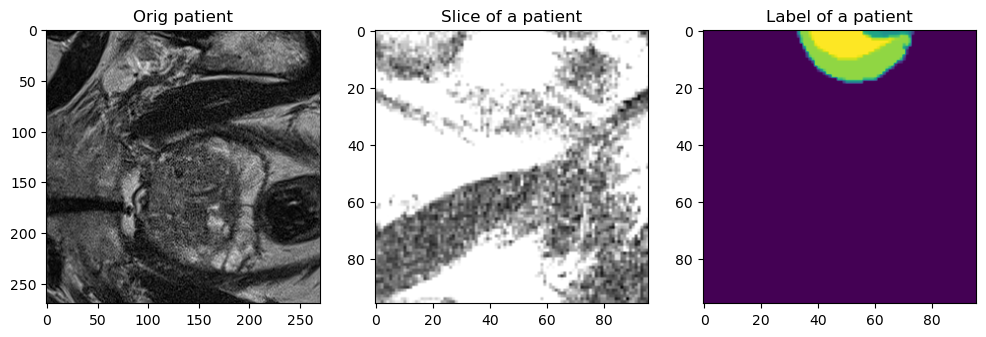

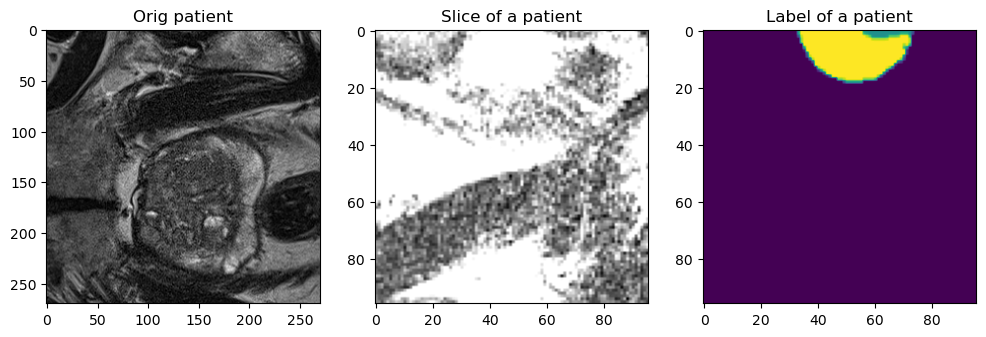

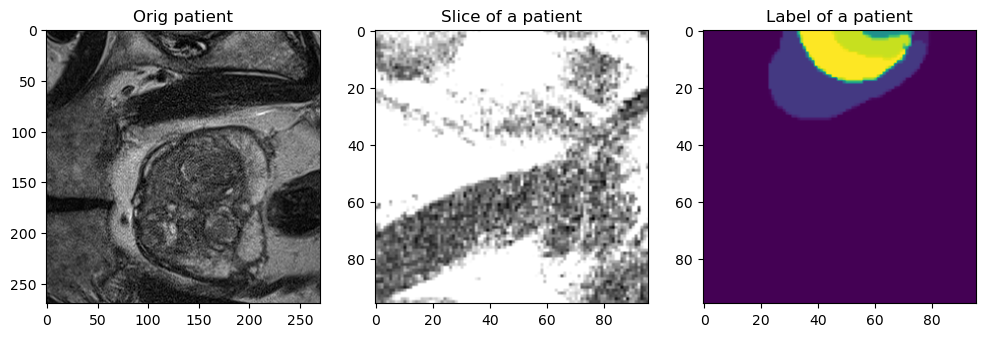

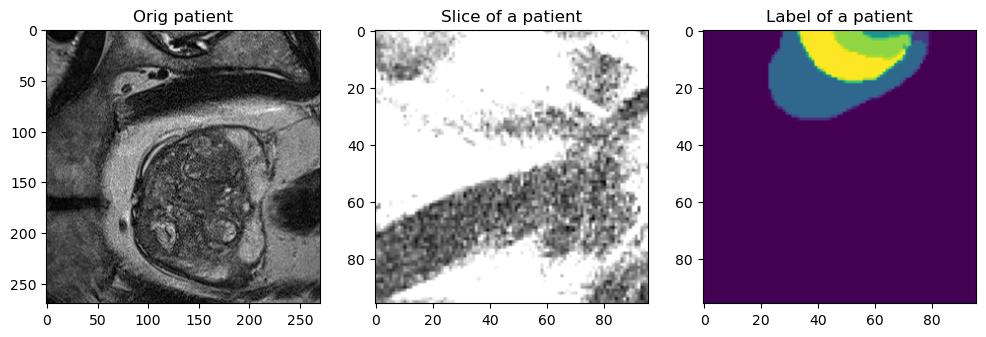

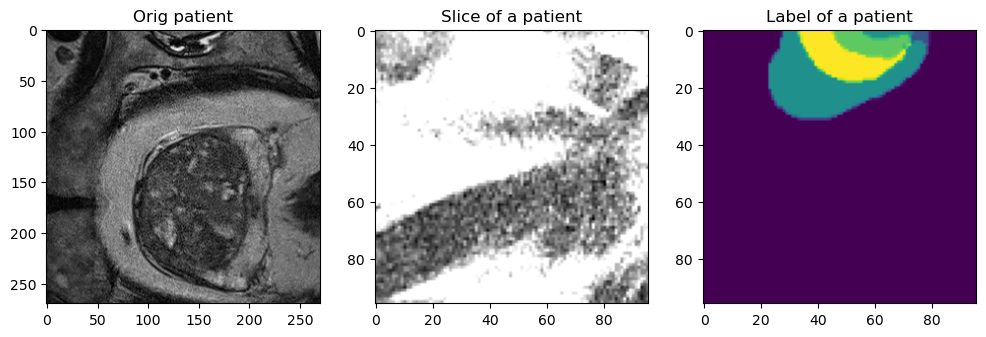

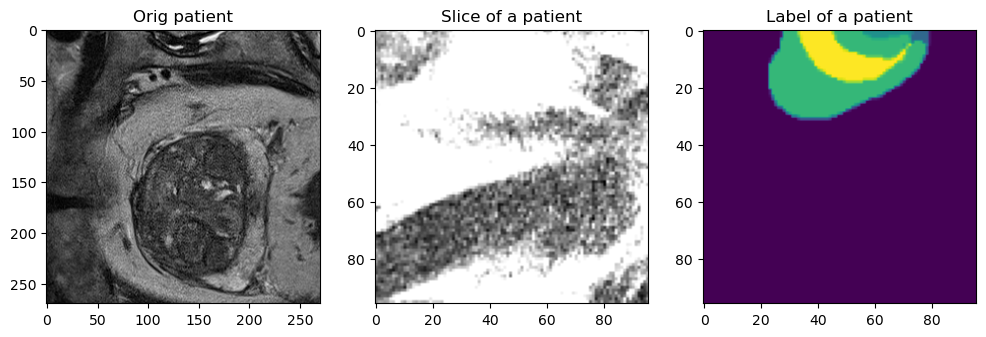

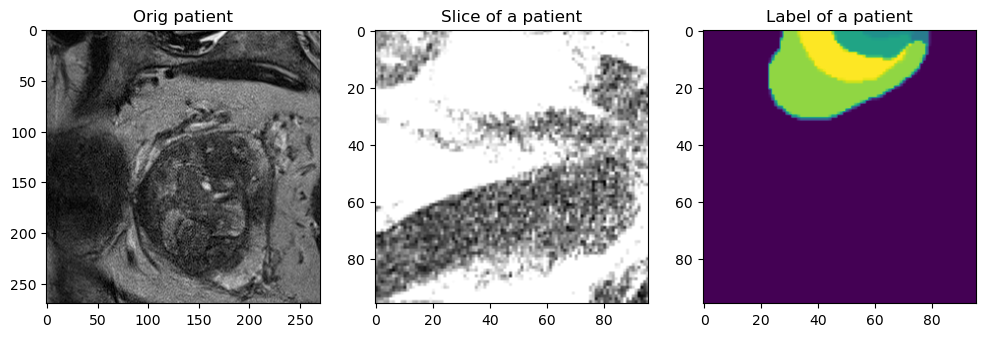

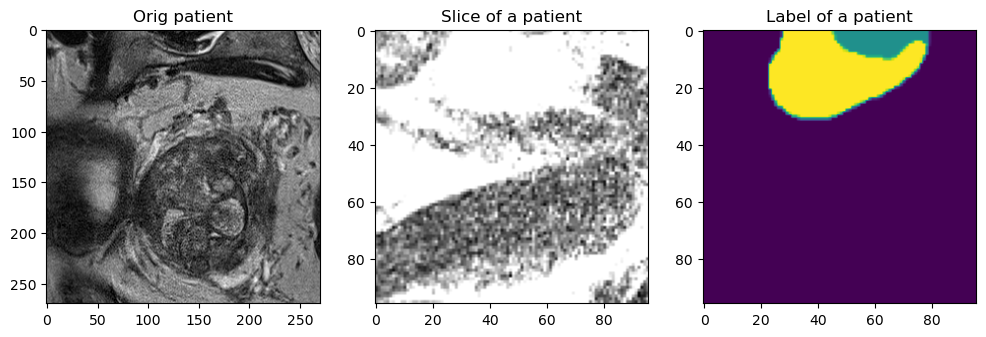

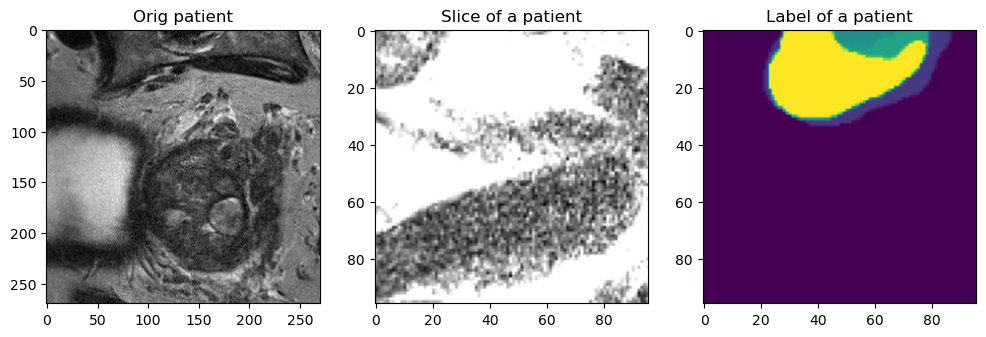

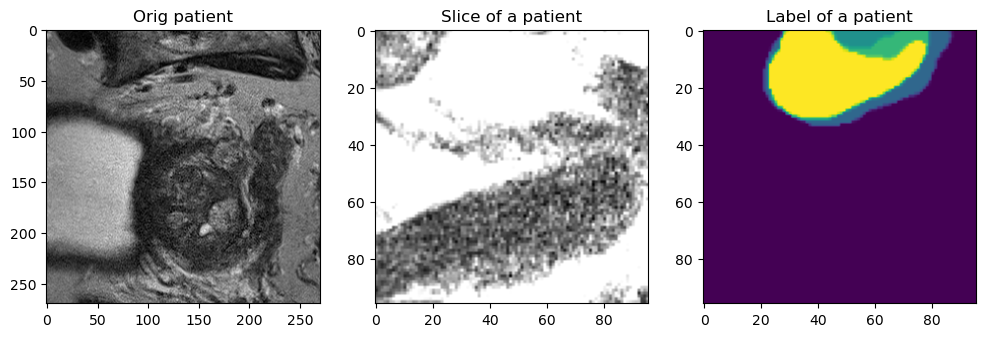

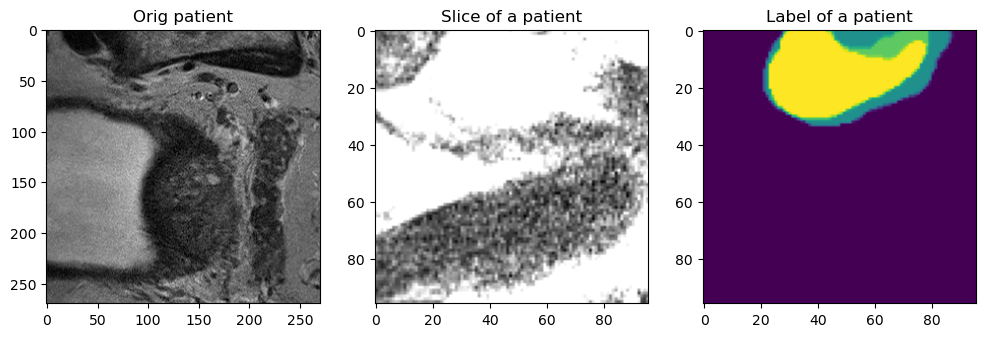

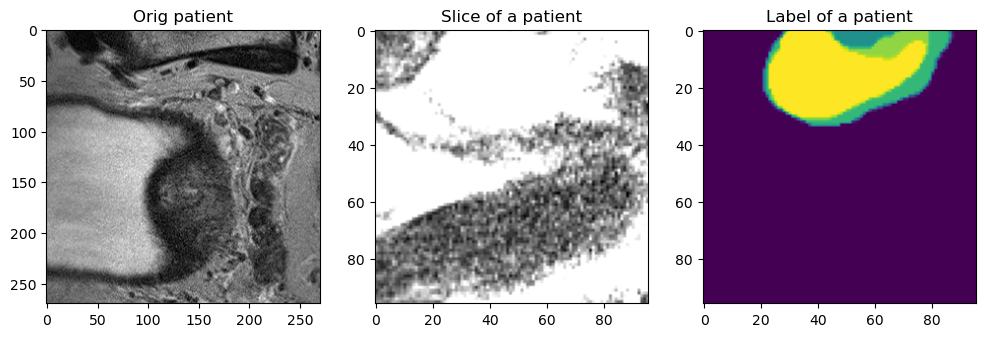

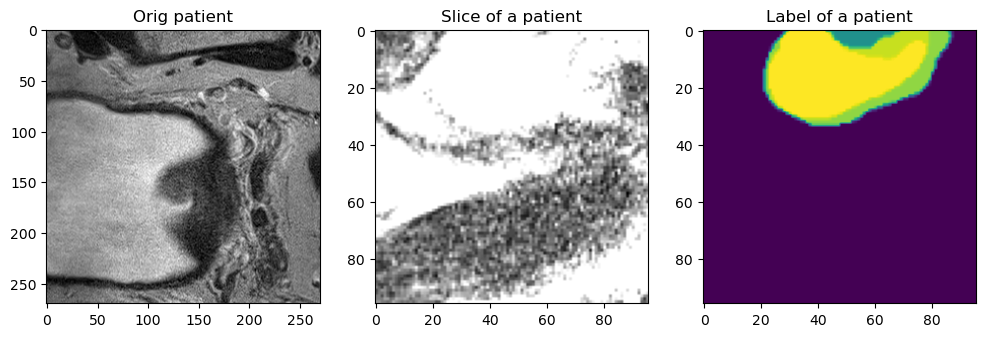

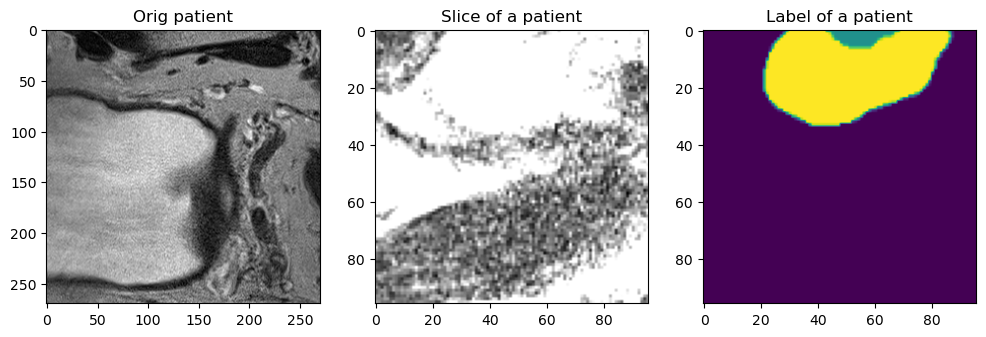

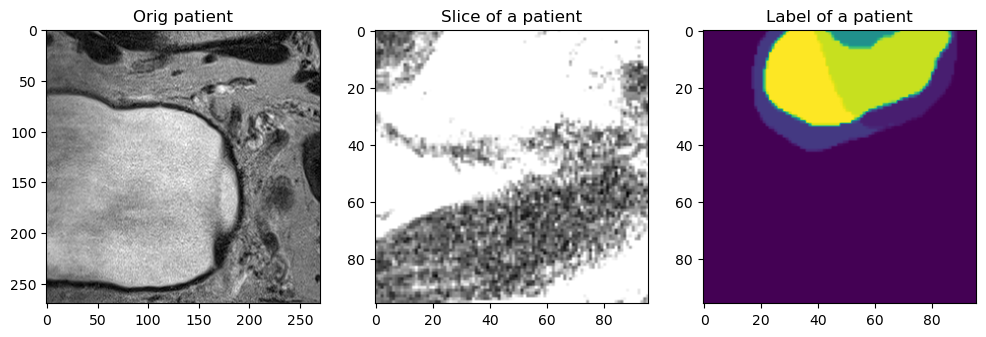

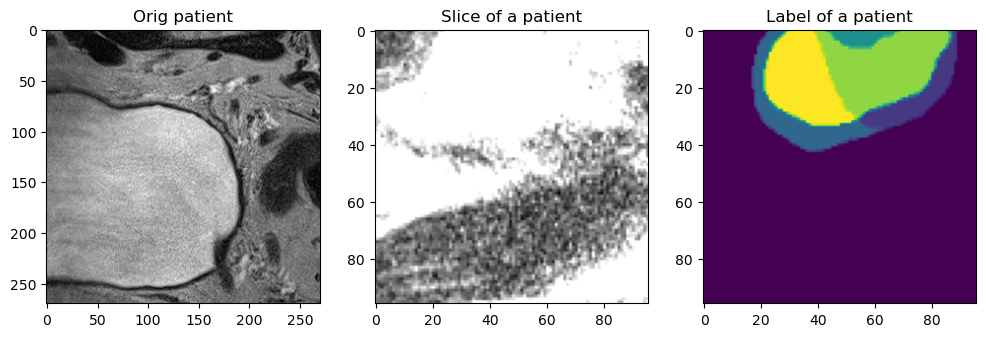

In [23]:
#plt.figure('test', (12, 6))
for i in range(28):
  plt.figure('test', (12, 6))
  plt.subplot(1, 3, 1)
  plt.title('Orig patient')
  plt.imshow(orig_patient['image'][0, 0, : ,: ,i], cmap= "gray")

  plt.subplot(1, 3, 2)
  plt.title('Slice of a patient')
  plt.imshow(test_patient['image'][0, 0, : ,: ,i], cmap= "gray")

  plt.subplot(1,3,3)
  plt.title('Label of a patient')
  plt.imshow(test_patient['label'][0, 0, : ,: ,i])
  plt.show()

In [24]:
from monai.losses import DiceCELoss
from monai.optimizers import Novograd

In [25]:
torch.cuda.is_available()

True

In [26]:
device = torch.device("cuda:0")
def get_model():
    return UNet(
        spatial_dims= 3,
        in_channels=1,
        out_channels=3,
        channels=[16, 32, 64, 128, 256, 512],
        strides=[2, 2, 2, 2, 2],
        num_res_units=4,
        act='PRELU',
        norm='BATCH',
        dropout=0.15,
            ).to(device)


In [27]:
model=get_model()
loss_function = DiceCELoss(include_background=False,softmax=True,to_onehot_y=True)
optimizer = Novograd(model.parameters(), lr=0.001,weight_decay=0.01 ,amsgrad=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [31]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
n_classes=3
post_pred = Compose([EnsureType(), AsDiscrete(keys=CommonKeys.LABEL,argmax=True, to_onehot=n_classes, num_classes=n_classes)])
post_label = Compose([EnsureType(), AsDiscrete(keys=CommonKeys.LABEL,to_onehot=n_classes, num_classes=n_classes)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (96, 96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model,overlap=0.5)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    "/kaggle/working/", "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/119, train_loss: 1.3457
2/119, train_loss: 1.2639
3/119, train_loss: 1.2978
4/119, train_loss: 1.2327
5/119, train_loss: 1.2353
6/119, train_loss: 1.3065
7/119, train_loss: 1.2194
8/119, train_loss: 1.4117
9/119, train_loss: 1.2193
10/119, train_loss: 1.2285
11/119, train_loss: 1.3332
12/119, train_loss: 1.3264
13/119, train_loss: 1.1516
14/119, train_loss: 1.2207
15/119, train_loss: 1.3868
16/119, train_loss: 1.4070
17/119, train_loss: 1.5183
18/119, train_loss: 1.1942
19/119, train_loss: 1.2911
20/119, train_loss: 1.2640
21/119, train_loss: 1.2064
22/119, train_loss: 1.6929
23/119, train_loss: 1.1816
24/119, train_loss: 1.2721
25/119, train_loss: 1.2624
26/119, train_loss: 1.2194
27/119, train_loss: 1.2532
28/119, train_loss: 1.2106
29/119, train_loss: 1.2629
30/119, train_loss: 1.4056
31/119, train_loss: 1.1585
32/119, train_loss: 1.1433
33/119, train_loss: 1.2328
34/119, train_loss: 1.3122
35/119, train_loss: 1.3379
36/119, train_loss: 1.1294
37/119, train_

In [30]:
#model.state_dict()

In [32]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7313 at epoch: 64


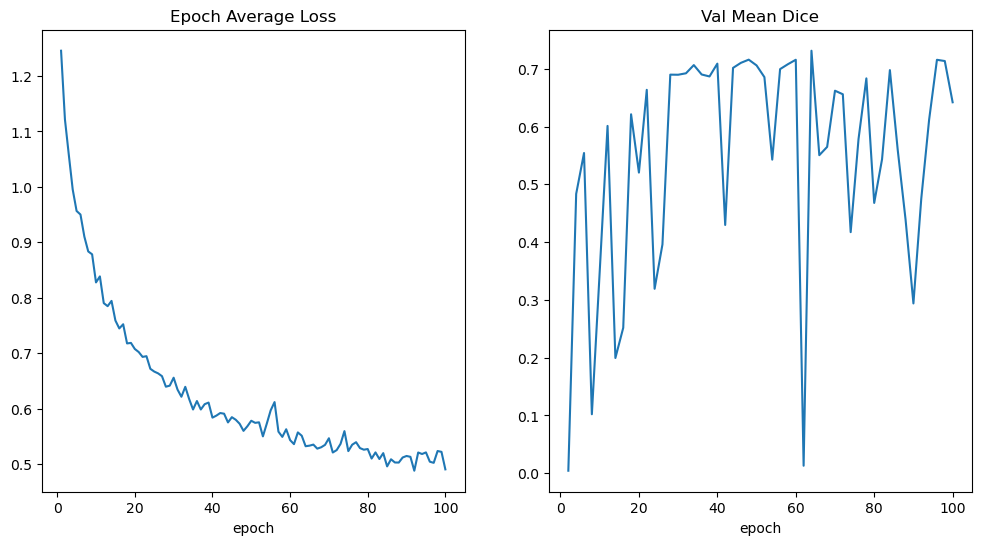

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()